# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [3]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [6]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
# Se escogio una porción 50/50
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

- review: el texto de la reseña
- pos: el objetivo, '0' para negativo y '1' para positivo
- ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

In [8]:
# Columnas de interes 
#  11  review           47331 non-null  object 
#  14  pos              47331 non-null  int64 
#  15  ds_part          47331 non-null  object 

# target = pos

In [9]:
# Verificamos que las columnas
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [10]:
df_reviews["sp"].unique()

array(['neg', 'pos'], dtype=object)

In [11]:
# Verifica si hay valores nulos
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [12]:
# Rellenar valores nulos fillna('unknown' o '0')
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(0)
df_reviews['votes'] = df_reviews['votes'].fillna(0)

In [13]:
# Verifica si hay valores nulos
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [14]:
# Contar duplicados explícitos
df_reviews.duplicated().sum()

0

In [15]:
# Verificamos imbalance, tenemos un 50 a 50 no existe imbalance, hay balance en las etiquetas 'pos'
df_reviews['pos'].mean()

0.4989541737972999

## EDA

In [16]:
# películas por año
# promedio del target por año (también desglosado por train y test set)
# histograma de reviews por película (separado por el target)
# comparar el histograma anterior por train y test set (normalizar en caso de que train y test no sean del mismo tamaño)
# longitud del texto (ver histograma y separarlo por target, también separarlo por train/test)

Veamos el número de películas y reseñas a lo largo de los años.

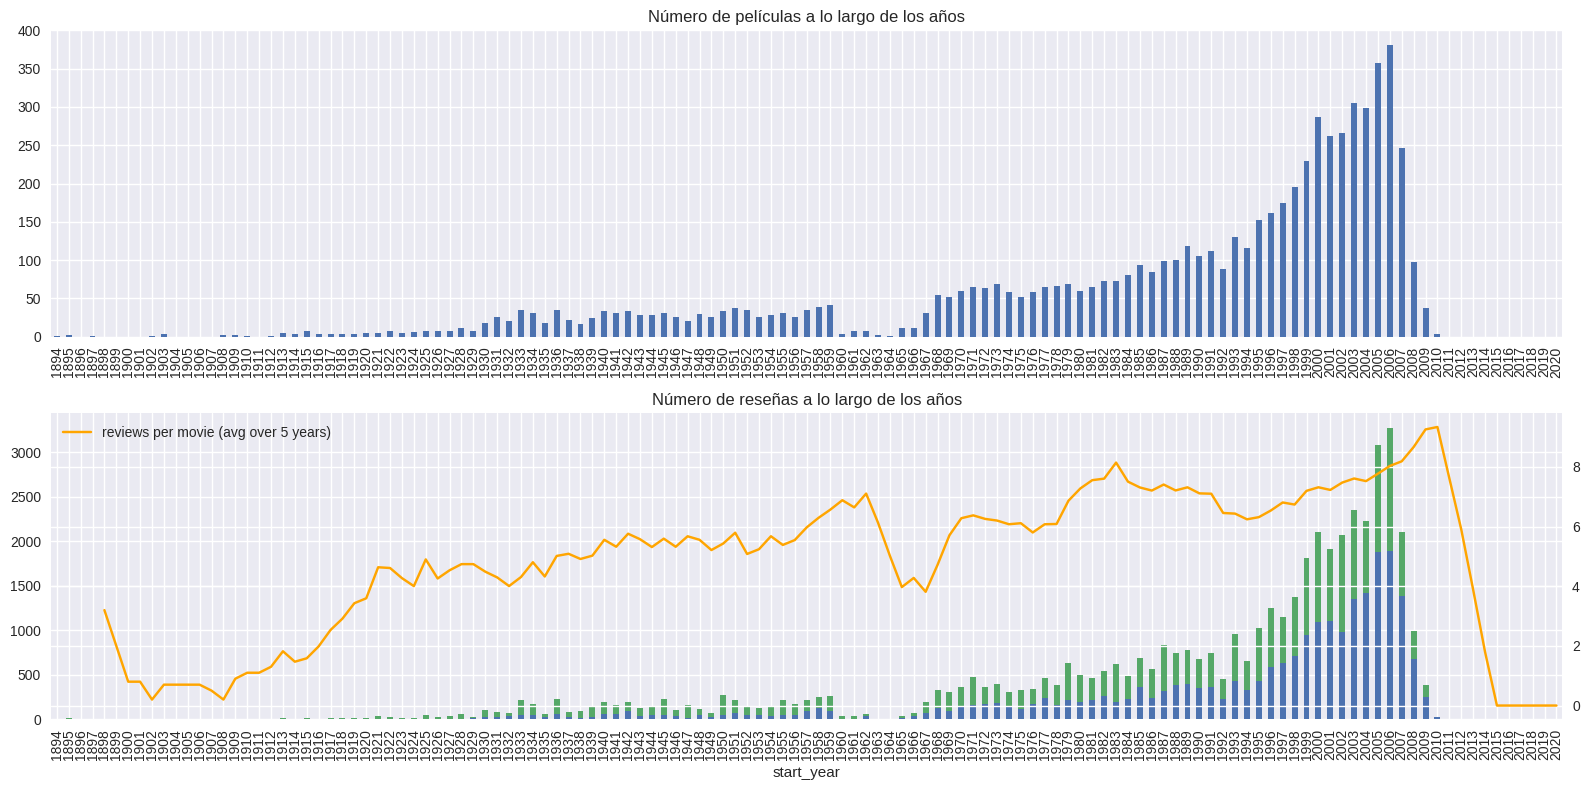

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

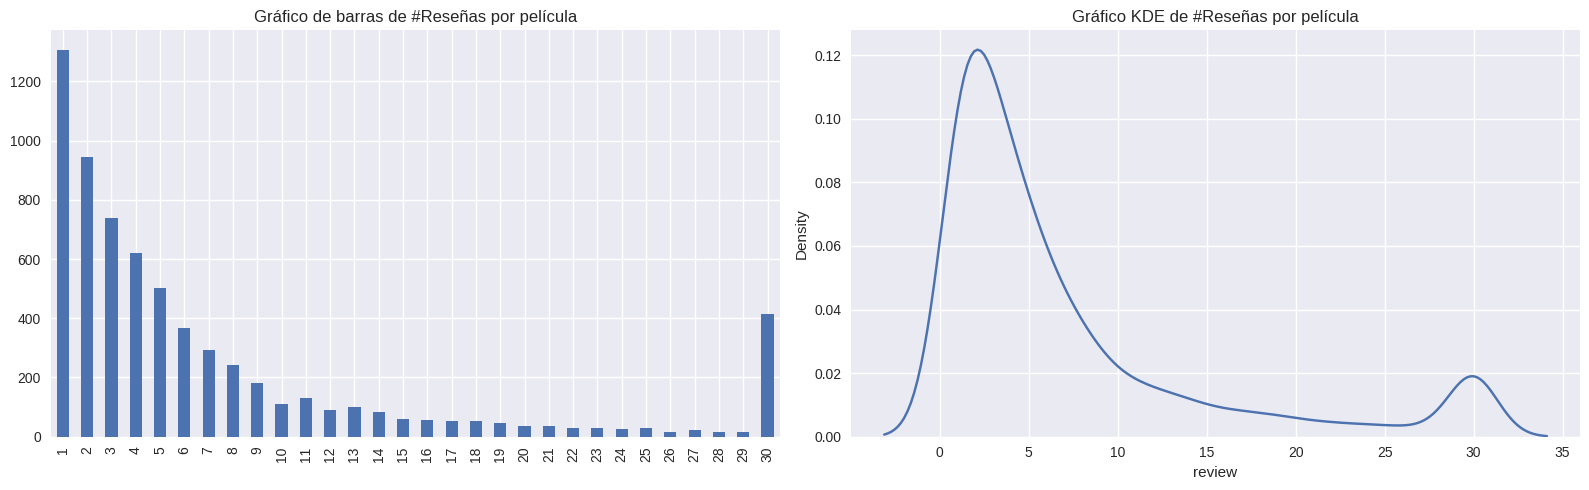

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [19]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

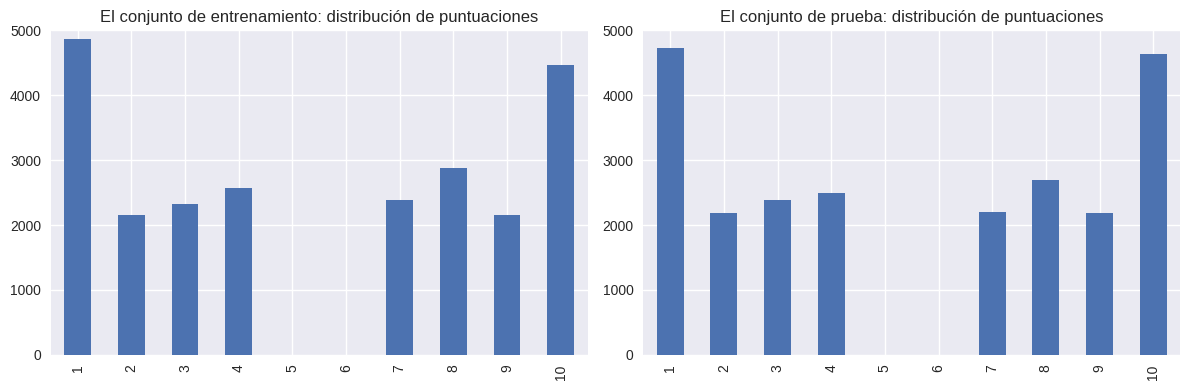

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


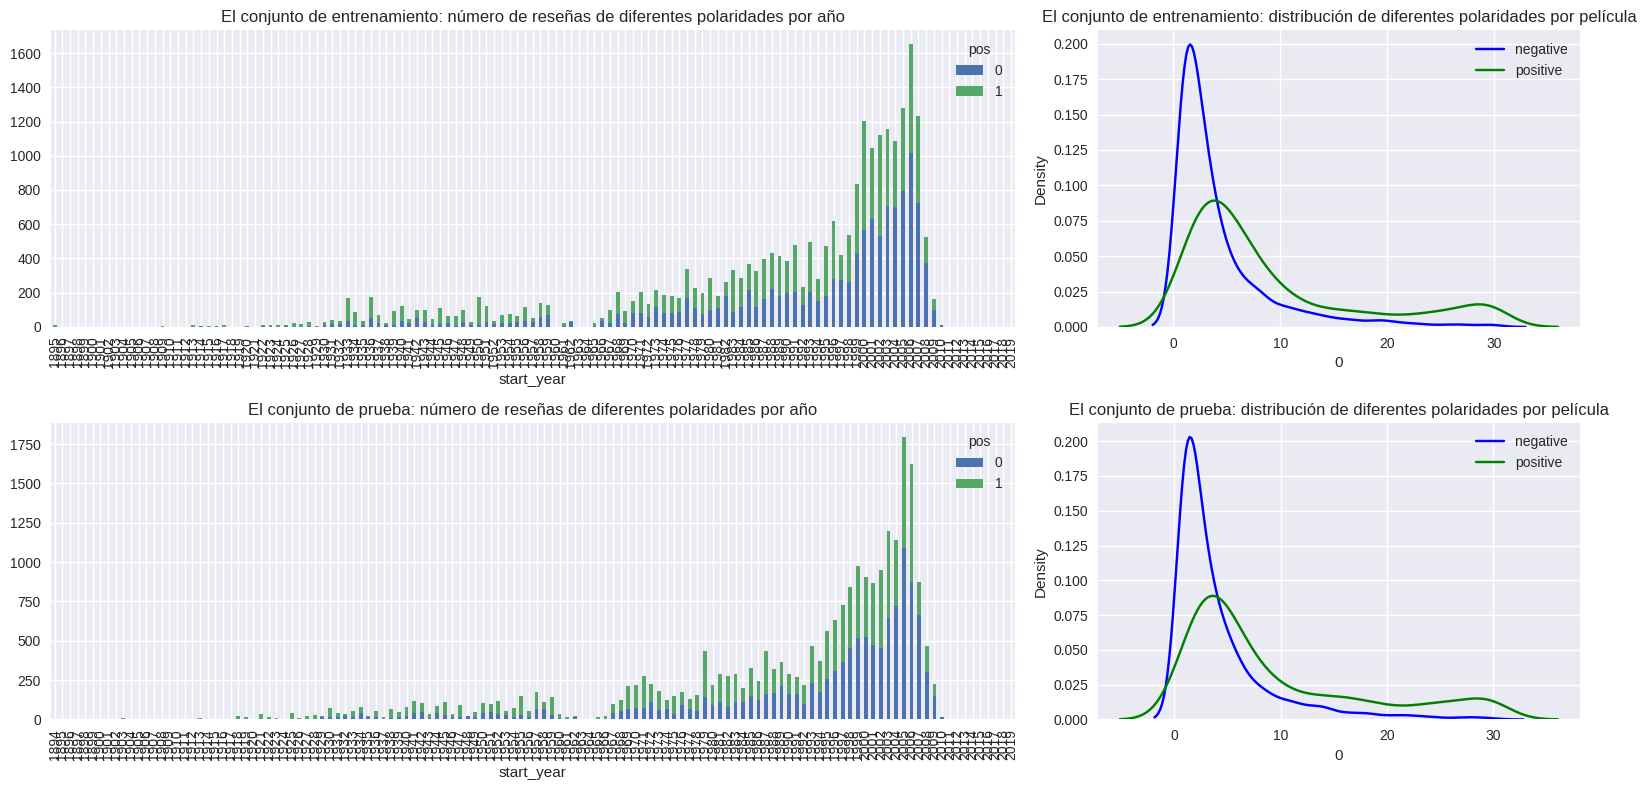

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [8]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [9]:
# La columna llamada 'original_title' con los textos originales
# Nueva columna 'review_norm' con los textos normalizados.

In [10]:
# Verificamos los textos, digitos, signos de puntuación, etc.
df_reviews['original_title'].unique()

array(['$', "'15'",
       "'Gung Ho!': The Story of Carlson's Makin Island Raiders", ...,
       'Æon Flux', 'Étude in Black', 'Îhatôbu gensô: KENjI no haru'],
      dtype=object)

In [11]:
# Verificamos las columnas existentes
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [12]:
# Elimina dígitos y signos de puntuación
df_reviews['review_norm'] = df_reviews['original_title'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Convierte todo a minúsculas
df_reviews['review_norm'] = df_reviews['review_norm'].str.lower()

# Ahora la columna 'review_norm' contiene los textos normalizados

In [13]:
# Comprobamos en el la tabla 'df_reviews'
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 1 - Constante

In [29]:
from sklearn.dummy import DummyClassifier

In [30]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Crear un clasificador Dummy con estrategia 'constant'
dummy_clf = DummyClassifier(strategy='constant', constant=0)  # Cambia el valor de 'constant' según tus necesidades

# Entrenar el modelo con los datos de entrenamiento
dummy_clf.fit(df_reviews_train[['review_norm', 'ds_part']], train_target)  # Reemplaza 'feature1', 'feature2', ... con las características relevantes

# Calcular la precisión en los datos de prueba
accuracy = dummy_clf.score(df_reviews_test[['review_norm', 'ds_part']], test_target)  # Reemplaza 'feature1', 'feature2', ... con las mismas características

print(f"Precisión del modelo Dummy (estrategia 'constant'): {accuracy:.2f}")


Precisión del modelo Dummy (estrategia 'constant'): 0.50


### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [15]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

# Evalúa el modelo (por ejemplo, usando accuracy_score o cualquier otra métrica relevante)
from sklearn.metrics import accuracy_score

In [16]:
# Descarga las stopwords de NLTK (si aún no las tienes)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Filtra las stopwords en español
stop_words = set(stopwords.words('spanish'))

In [18]:
# evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

In [19]:
# Vectorización TF-IDF
# Ajusta el número de características según tus necesidades

tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words, max_features=1000)

In [20]:
# Transforma los textos de entrenamiento y prueba
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm']) 
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm']) 

In [21]:
# Modelo de Regresión Logística
model_2 = LogisticRegression(max_iter=1000)  # Aumenta el número de iteraciones
model_2.fit(train_features_2, train_target)

# Calcula las predicciones en datos de prueba
test_predictions = model_2.predict(test_features_2)

# Calcula la precisión
accuracy = accuracy_score(test_target, test_predictions)

print(f"Precisión del modelo 2 en datos de prueba: {accuracy:.2f}")

Precisión del modelo 2 en datos de prueba: 0.53


           train  test
Exactitud    NaN   NaN
F1          0.75  0.33
APS         0.85  0.52
ROC AUC     0.85  0.53


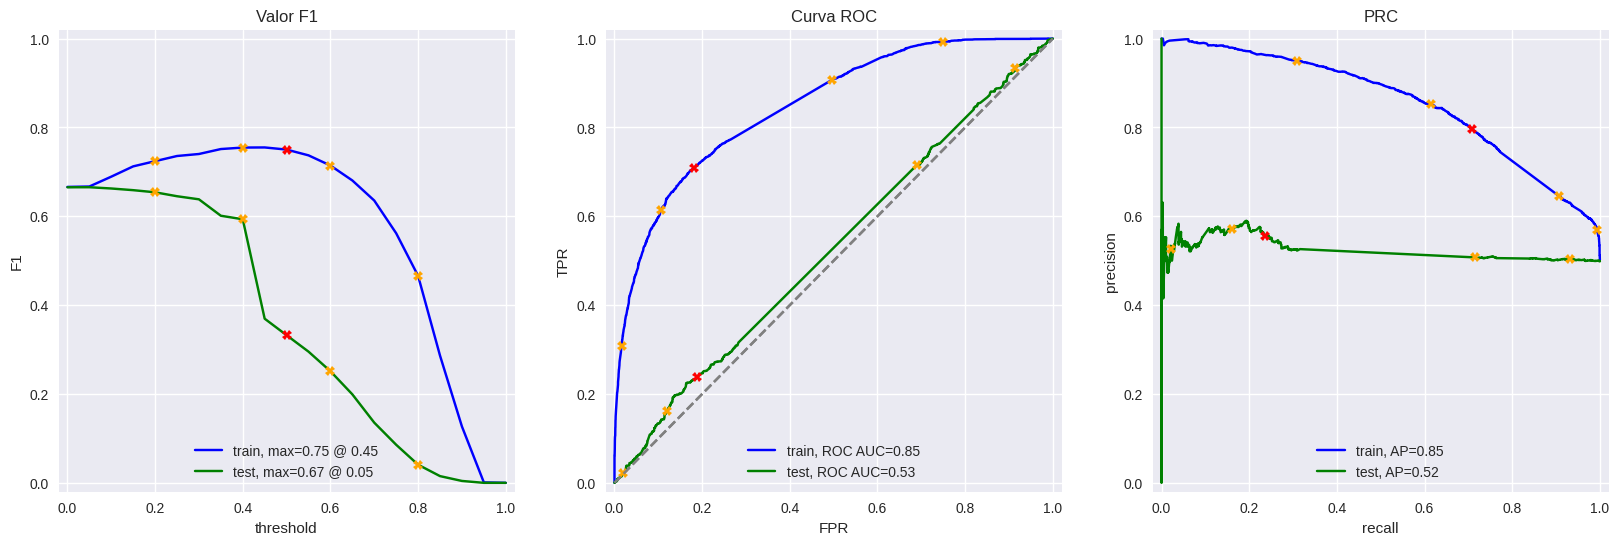

In [22]:
# evaluate_model(características de entrenamiento, etiquetas de entrenamiento, características de prueba y etiquetas de prueba).

evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [25]:
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Carga el modelo de lenguaje de spaCy (por ejemplo, 'en_core_web_sm')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
# Función para preprocesar el texto utilizando spaCy
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [27]:
# Aplica la función de preprocesamiento a tus datos (por ejemplo, df_reviews['ds_part']) # df_reviews['review_norm'])
df_reviews_train['review_processed'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_processed'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [28]:
# Vectorización TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(max_features=1000)  # Ajusta el número de características según tus necesidades
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_processed'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_processed'])

In [29]:
# Modelo de Regresión Logística
model_3 = LogisticRegression(max_iter=1000)  # Aumenta el número de iteraciones
model_3.fit(train_features_3, train_target)

# Predicciones en datos de prueba
predictions = model_3.predict(test_features_3)

# Evalúa el modelo (por ejemplo, usando accuracy_score o cualquier otra métrica relevante)
accuracy = accuracy_score(test_target, predictions)
print(f"Precisión del Modelo 3 en datos de prueba: {accuracy:.2f}")

Precisión del Modelo 3 en datos de prueba: 0.52


           train  test
Exactitud    NaN   NaN
F1          0.76  0.35
APS         0.85  0.52
ROC AUC     0.85  0.53


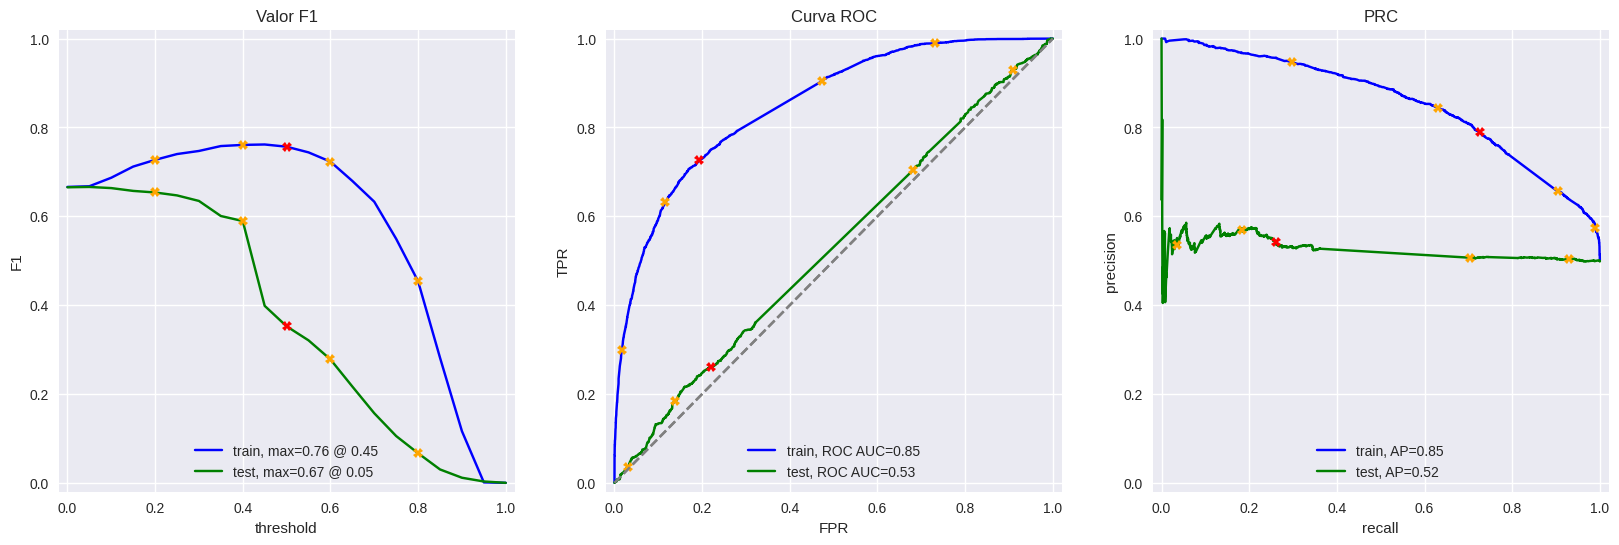

In [30]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [46]:
# tfidf_vectorizer = features_1_vectorizer
# X_train_tfidf = train_features_1
# X_test_tfidf = test_features_1

In [47]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Carga el modelo de lenguaje de spaCy (por ejemplo, 'en_core_web_sm')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [48]:
# Función para preprocesar el texto utilizando spaCy
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

# Aplica la función de preprocesamiento a tus datos (por ejemplo, df_reviews['review_norm'])
df_reviews_train['review_processed'] = df_reviews_train['review_norm'].apply(text_preprocessing_4)
df_reviews_test['review_processed'] = df_reviews_test['review_norm'].apply(text_preprocessing_4)

# Vectorización TF-IDF
features_4_vectorizer = TfidfVectorizer(max_features=1000)  # Ajusta el número de características según tus necesidades
train_features_4 = features_4_vectorizer.fit_transform(df_reviews_train['review_processed'])
test_features_4 = features_4_vectorizer.transform(df_reviews_test['review_processed'])

# Modelo LGBMClassifier
model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)

# Predicciones en datos de prueba
predictions = model_4.predict(test_features_4)

# Evalúa el modelo (por ejemplo, usando accuracy_score u otras métricas relevantes)
accuracy = accuracy_score(test_target, predictions)
print(f"Precisión del Modelo 4 en datos de prueba: {accuracy:.2f}")

Precisión del Modelo 4 en datos de prueba: 0.52


           train  test
Exactitud    NaN   NaN
F1          0.73  0.27
APS         0.85  0.52
ROC AUC     0.85  0.53


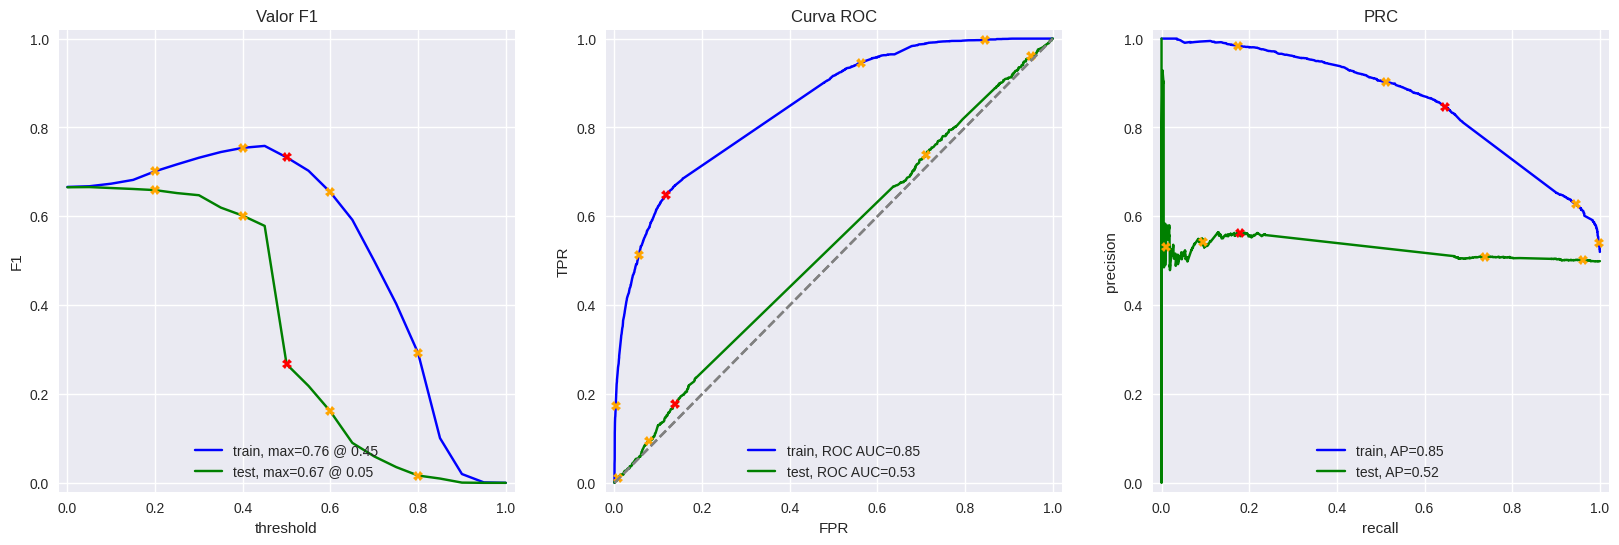

In [49]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Modelo 9 - BERT

In [50]:
import torch
import transformers

import numpy as np
from tqdm import tqdm
import math

In [51]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased') # BertModel

# BertForSequenceClassification

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # Convertir texto a IDs de tokens junto con sus máscaras de atención
    for text in texts:
        encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        ids_list.append(encoded_text['input_ids'])
        attention_mask_list.append(encoded_text['attention_mask'])
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [1]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas

# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu') # cpu #cuda

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [ ]:
# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [23]:
# Definir las reseñas
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalizar las reseñas (por ejemplo, convertir todo a minúsculas y eliminar signos de puntuación)
my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^\w\s]', '')

# Mostrar el DataFrame resultante
my_reviews


,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 2

In [24]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.46:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.18:  i was really fascinated with the movie
0.42:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.56:  i didnt expect the reboot to be so good writers really cared about the source material
0.60:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.43:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.67:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [31]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.31:  i did not simply like it not my kind of movie
0.29:  well i was bored and felt asleep in the middle of the movie
0.39:  i was really fascinated with the movie
0.47:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.38:  i didnt expect the reboot to be so good writers really cared about the source material
0.59:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.33:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

- Precisión del modelo Dummy (estrategia 'constant'): 0.50
    
- Modelo 2 Precisión del modelo en datos de prueba: 0.53 LogisticRegression
        F1          train 0.75  test 0.33
- Modelo 3 Precisión del Modelo 3 en datos de prueba: 0.52
        F1          train 0.76  test 0.35
- Precisión del Modelo 4 en datos de prueba: 0.52
        F1          train 0.73  test .27

- El Modelo 2 parece tener la mejor precisión en datos de prueba, aunque su F1-score en prueba es relativamente bajo. 
- El Modelo 3 también tiene una buena precisión, pero su F1-score es un poco más alto. 
- El Modelo 4 tiene una precisión similar al Modelo 3, pero su F1-score en prueba es el más bajo.

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 